In [1]:
# install packages if imports dont work

import numpy as np
import pandas as pd
import seaborn as sns
import os
from numpy.polynomial import polynomial as P
from matplotlib import pyplot as plt

#### Information about the data set:

Title: Inferring strategies from observations in long iterated prisoner’s dilemma experiments

Link: https://datadryad.org/stash/dataset/doi:10.5061%2Fdryad.37pvmcvmk

Game: Repeated PD randomly; matched partners

Payoff matrix:


| Player\Opponent | C        | D    |
| ------          | ----- | ---- |
| **C**           | (3, 3)     | (0, 4) |
| **D**           | (4, 0)     | (1, 1) |

In [2]:
# Get csv data

#print(os.getcwd())
path = 'C:/Users/1412r/OneDrive/Desktop/rand.xlsx'
df = pd.read_excel(path)

#df.head()
#df.describe()

In [3]:
# Housekeeping

drop_cols = ['time_php', 'time_js', 'treatment', 'context', 'prev', 'prev_player',  'prev_opp', 'session']
df.drop(columns=drop_cols, inplace=True)

In [4]:
# Add column for the partner's payoff

df['payoff_opponent'] = df['payoff'] # Payoffs are same when both take the same action
df['payoff_opponent'].loc[(df['action_player']=='C') & (df['action_opponent']=='D')] = 4
df['payoff_opponent'].loc[(df['action_player']=='D') & (df['action_opponent']=='C')] = 0

C:\Users\1412r\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [5]:
df.head()

,round,player,action_player,opponent,action_opponent,payoff,payoff_opponent
0,1,s11n9usuario1,C,s11n9usuario10,C,3,3
1,2,s11n9usuario1,C,s11n9usuario10,D,0,4
2,3,s11n9usuario1,C,s11n9usuario7,C,3,3
3,4,s11n9usuario1,C,s11n9usuario8,D,0,4
4,5,s11n9usuario1,C,s11n9usuario7,C,3,3


In [6]:
# Checking how the dataset looks

print(f'The shape of df is {df.shape}\n')
#print(df.groupby(['player']).count())
print(df.info())
df.describe()

The shape of df is (9600, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9600 entries, 0 to 9599
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   round            9600 non-null   int64 
 1   player           9600 non-null   object
 2   action_player    9600 non-null   object
 3   opponent         9600 non-null   object
 4   action_opponent  9600 non-null   object
 5   payoff           9600 non-null   int64 
 6   payoff_opponent  9600 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 525.1+ KB
None


,round,payoff,payoff_opponent
count,9600.000000,9600.000000,9600.000000
mean,50.500000,1.570417,1.570417
std,28.867574,1.421502,1.421502
min,1.000000,0.000000,0.000000
25%,25.750000,1.000000,1.000000
50%,50.500000,1.000000,1.000000
75%,75.250000,3.000000,3.000000
max,100.000000,4.000000,4.000000


#### Notes
1. No null elements
2. Mostly 100 trials per subject, but not always (account for this while calculating error)

The number of rows with equal payoffs is 5744


<AxesSubplot:>

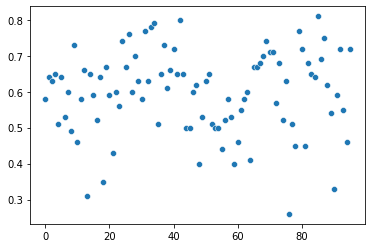

In [7]:
# Checking fraction of rows with equal payoffs

number_of_participants = len(df['player'].unique())
x = (df[df['payoff']==df['payoff_opponent']]).shape[0]
print(f'The number of rows with equal payoffs is {x}')

frac = (df[df['payoff']==df['payoff_opponent']].value_counts(subset=['player'])/df.value_counts(subset=['player']))
sns.scatterplot(y=frac, x=range(number_of_participants))

Again, atleast 1/3 of rows have equal payoff for both self and other for every participant

Payoff matrix:


| Player\Opponent | C        | D    |
| ------          | ----- | ---- |
| **C**           | $$(3, 3)$$     | $$(4\alpha_1, 4)$$ |
| **D**           | $$(4(1-\beta_1), 0)$$     | $$(1, 1)$$ |

Best response of the player (format: (when opponent plays C, when opponent plays D)):

|  | $$\alpha < \frac{1}{4}$$      | $$\alpha > \frac{1}{4}$$   |
| ------          | ----- | ---- |
| **$$\beta < \frac{1}{4}$$**           | (D, D)     | (D, C) |
| **$$\beta > \frac{1}{4}$$**           | (C, D)     | (C, C) |

For 0 level player, belief about opponent's parameters: alpha = beta = 0. Thus, the opponent will play D. So the best response will be to play D if $\alpha$ is less than 1/4 and C otherwise. **(Checkpoint)**

In [8]:
# Grid parameters

steps = 11 ##### Input number of steps here
N = df.shape[0]

alpha_range = np.linspace(0, 1, steps, endpoint=True)
beta_range  = np.linspace(0, 1, steps, endpoint=True)
col = []

for alpha in alpha_range: 
    for beta in beta_range: 
        name = str(alpha), str(beta)
        col  = col + [name]

In [9]:
# Create empty dataframes
utilities = pd.DataFrame(index=df.index, columns=col) # utility matrix
error = pd.DataFrame(index=df.index, columns=col)     # error matrix

In [10]:
# Utility Grid: D for alpha < 0.25 and C for alpha > 0.25 (no equality in 11 steps' case)

for i in range(len(utilities.columns)):
    x = float(utilities.columns[i][0])
    if x < 0.25:
        utilities.iloc[:, i] = 'D'
    if x > 0.25:
        utilities.iloc[:, i] = 'C'

Not dropping rows with equal payoffs for now **(Checkpoint)**

In [11]:
# Calculating error matrix

for x in col:
    error[x] = utilities[x]==df['action_player']
    
error = 1 - error # Converting to ones and zeros from trues and falses
error['player'] = df['player'] # Adding player column for easier future calculations

In [21]:
# Calculate average error for each participant

data = []

for i in df['player'].unique():
    sum_of_error = (error[error['player']==i]).sum()
    number_of_trials = (df['player']==i).sum()
    print(type(sum_of_error/number_of_trials))
    #data = data + [sum_of_error/number_of_trials]
    
avg_error = pd.DataFrame(data=data)

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [28]:
sum_of_error.divide(other=number_of_trials)

TypeError: unsupported operand type(s) for /: 'str' and 'int'

100